# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [3]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-20 09:00:00+09:00,48332.710938,48445.769531,48254.828125,48360.078125,0,0.0,0.0
2025-10-20 09:15:00+09:00,48367.820312,48535.890625,48367.820312,48500.589844,0,0.0,0.0
2025-10-20 09:30:00+09:00,48494.988281,48769.460938,48486.578125,48763.910156,0,0.0,0.0
2025-10-20 09:45:00+09:00,48763.140625,48805.031250,48690.878906,48731.789062,0,0.0,0.0
2025-10-20 10:00:00+09:00,48726.949219,48795.750000,48718.960938,48766.378906,0,0.0,0.0
2025-10-20 10:15:00+09:00,48768.960938,48810.519531,48760.550781,48807.710938,0,0.0,0.0
2025-10-20 10:30:00+09:00,48804.980469,48927.031250,48801.109375,48926.070312,0,0.0,0.0
2025-10-20 10:45:00+09:00,48922.980469,48939.828125,48838.160156,48897.398438,0,0.0,0.0
2025-10-20 11:00:00+09:00,48898.539062,48927.308594,48843.031250,48889.851562,0,0.0,0.0


## 前日終値の取得

In [4]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-14 00:00:00+09:00    46847.320312
2025-10-15 00:00:00+09:00    47672.671875
2025-10-16 00:00:00+09:00    48277.738281
2025-10-17 00:00:00+09:00    47582.148438
2025-10-20 00:00:00+09:00    48940.628906
Name: Close, dtype: float64


Date
2025-10-17 00:00:00+09:00    47582.148438
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [5]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+750.56


## ローソク足チャート（小さいサイズ）

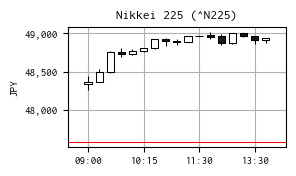

In [6]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [7]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [8]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-17 08:00:00+09:00,150.251999,150.292007,150.188995,150.223007,0,0.0,0.0
2025-10-17 08:15:00+09:00,150.220993,150.235001,150.115005,150.136002,0,0.0,0.0
2025-10-17 08:30:00+09:00,150.130997,150.147995,150.046005,150.061996,0,0.0,0.0
2025-10-17 08:45:00+09:00,150.061996,150.154999,150.050003,150.149002,0,0.0,0.0
2025-10-17 09:00:00+09:00,150.147995,150.227997,150.054001,150.119995,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-20 13:00:00+09:00,150.718994,150.768997,150.671997,150.695007,0,0.0,0.0
2025-10-20 13:15:00+09:00,150.694000,150.697998,150.604996,150.617004,0,0.0,0.0
2025-10-20 13:30:00+09:00,150.617004,150.619995,150.501999,150.544998,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [9]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-20 09:00:00+09:00,320.334498,321.083816,319.818314,320.515879
2025-10-20 09:15:00+09:00,320.633082,321.747229,320.633082,321.513218
2025-10-20 09:30:00+09:00,321.512314,323.332014,321.456556,323.295214
2025-10-20 09:45:00+09:00,323.131571,323.409161,322.652725,322.923818
2025-10-20 10:00:00+09:00,322.556174,323.011612,322.503294,322.817185
2025-10-20 10:15:00+09:00,322.678352,322.953323,322.622707,322.934740
2025-10-20 10:30:00+09:00,323.196800,324.005046,323.171165,323.998683
2025-10-20 10:45:00+09:00,324.098410,324.210021,323.536504,323.928938
2025-10-20 11:00:00+09:00,324.127608,324.318309,323.759670,324.070022


### 前日の終値のドル円レートから、前日の終値のドル換算

In [10]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-17 15:15:00+09:00


np.float64(149.79100036621094)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 317.6569241220805


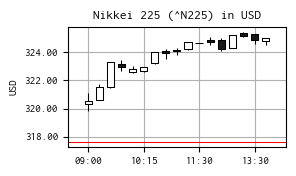

In [11]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()